In [1]:
!pip install torch_snippets
from torch_snippets import inspect, show,np,torch,nn
from torchvision.models import resnet50
model = resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model = model.eval()
import requests
from PIL import Image
url = 'https://lionsvalley.co.za/wp-content/uploads/2015/11/african-elephant-square.jpg'

original_image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
original_image = np.array(original_image)
original_image = torch.Tensor(original_image)

     |████████████████████████████████| 57 kB 4.2 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 208 kB 46.3 MB/s 
     |████████████████████████████████| 51 kB 7.0 MB/s 


2021-08-05 13:27:19.311 | WARNING  | torch_snippets.torch_loader:<module>:233 - Error: No module named 'pytorch_lightning'
Not importing Lightning Report
2021-08-05 13:27:20.004 | WARNING  | torch_snippets:<module>:14 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [2]:
image_net_classes = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
image_net_classes = requests.get(image_net_classes).text
image_net_ids = eval(image_net_classes)
image_net_classes = {i:j for j,i in image_net_ids.items()}

In [9]:
from torchvision import transforms as T
from torch.nn import functional as F
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalize = T.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])
def image2tensor(input):
    x = normalize(input.clone().permute(2,0,1)/255.)[None]
    return x
def tensor2image(input):
    x = (denormalize(input[0].clone()).permute(1,2,0)*255.).type(torch.uint8)
    return x

In [10]:
def predict_on_image(input):
    model.eval()
    show(input)
    input = image2tensor(input)
    pred = model(input)
    pred = F.softmax(pred,dim=-1)[0]
    prob,clss = torch.max(pred,0)
    clss = image_net_ids[clss.item()]
    print(f'PREDICTION: `{clss}` @ {prob.item()}')

In [11]:
from tqdm import trange
losses = []
def attack(image, model, target, epsilon=1e-6):
    input = image2tensor(image)
    input.requires_grad = True
    pred = model(input)
    loss = nn.CrossEntropyLoss()(pred, target)
    loss.backward()
    losses.append(loss.mean().item())
    output = input - epsilon * input.grad.sign()
    output = tensor2image(output)
    del input
    return output.detach()

In [12]:
modified_images = []
desired_targets = ['lemon', 'comic book', 'sax, saxophone']

In [13]:
for target in desired_targets:
    target = torch.tensor([image_net_classes[target]])
    image_to_attack = original_image.clone()
    for _ in trange(10):
        image_to_attack = attack(image_to_attack, model, target)
    modified_images.append(image_to_attack)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


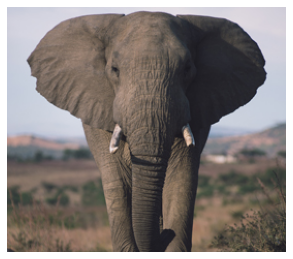

PREDICTION: `African elephant, Loxodonta africana` @ 0.5234402418136597
Tensor	Shape: torch.Size([237, 270, 3])	Min: 17.000	Max: 255.000	Mean: 110.237	dtype: torch.float32


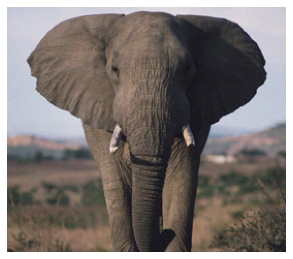

PREDICTION: `lemon` @ 0.9999936819076538
Tensor	Shape: torch.Size([237, 270, 3])	Min: 12.000	Max: 248.000	Mean: 105.232	dtype: torch.uint8


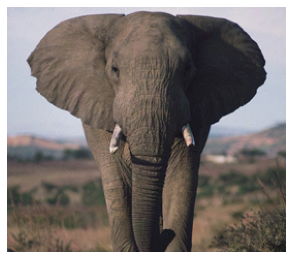

PREDICTION: `comic book` @ 0.9999727010726929
Tensor	Shape: torch.Size([237, 270, 3])	Min: 9.000	Max: 245.000	Mean: 105.230	dtype: torch.uint8


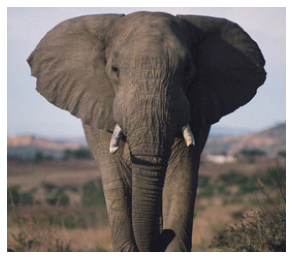

PREDICTION: `sax, saxophone` @ 0.9999992847442627
Tensor	Shape: torch.Size([237, 270, 3])	Min: 10.000	Max: 245.000	Mean: 105.239	dtype: torch.uint8


In [14]:
for image in [original_image, *modified_images]:
    predict_on_image(image)
    inspect(image)